Correct for dust extinction due to the extinction within the galaxy (should be a function of inclination).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import astropy.constants as const
import astropy.units as u

from hyperfit.linfit import LinFit

import time

import corner

import pickle

import matplotlib.pyplot as plt
# %matplotlib widget <-- UNCOMMENT FOR 3D PLOTS

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## Galaxies

In [3]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'

# gals_filename = 'SGA-2020_fuji_Vrot_phot-K-Corr.fits'
gals_filename = 'SGA-2020_fuji_Vrot.fits'

gals = Table.read(gals_directory + gals_filename)

In [4]:
gals[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,2.44404472261522e-05,65.28941302448953,11.227243824610715
1548,SGA-2020 1548,SDSSJ1

# Empirical internal dust extinction correction

Can we find (and correct for) any correlation between the axis ratio and the color of the galaxies?

## Calculate the "known" photometric corrections

### Survey offsets

In [5]:
SGA_filename = 'SGA-2020_fuji_Vrot_photsys.fits'
SGA = Table.read(gals_directory + SGA_filename)
SGA_photsys = SGA['SGA_ID', 'PHOTSYS']

# Add PHOTOSYS column to target tables
gals = join(gals, SGA_photsys, join_type='left', keys='SGA_ID')

In [6]:
sys_corr, sys_corr_err = BASS_corr(gals['PHOTSYS'])

### Dust corrections

In [7]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [8]:
dust_corr, dust_corr_err = MW_dust(gals['RA'], gals['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [9]:
# Flip NaN values to 0
dust_corr_err[np.isnan(dust_corr_err)] = 0

### $K$-corrections

In [10]:
kcorr = k_corr(gals['Z_DESI'], 
               [gals['G_MAG_SB26'], gals['R_MAG_SB26'], gals['Z_MAG_SB26']], 
               [gals['G_MAG_SB26_ERR'], gals['R_MAG_SB26_ERR'], gals['Z_MAG_SB26_ERR']])

## Apply "known" corrections

In [11]:
gals['G_MAG_SB26_CORR'] = gals['G_MAG_SB26'] - dust_corr[0] + sys_corr + kcorr[:,0]
gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26'] - dust_corr[1] + sys_corr + kcorr[:,1]
gals['Z_MAG_SB26_CORR'] = gals['Z_MAG_SB26'] - dust_corr[2] + sys_corr + kcorr[:,2]

In [12]:
gals['G_MAG_SB26_ERR_CORR'] = np.sqrt(gals['G_MAG_SB26_ERR']**2 + dust_corr_err[0]**2 + sys_corr_err**2)
gals['R_MAG_SB26_ERR_CORR'] = np.sqrt(gals['R_MAG_SB26_ERR']**2 + dust_corr_err[1]**2 + sys_corr_err**2)
gals['Z_MAG_SB26_ERR_CORR'] = np.sqrt(gals['Z_MAG_SB26_ERR']**2 + dust_corr_err[2]**2 + sys_corr_err**2)

## Convert $R_{26}$ to kpc

In [13]:
dist = Distance(z=gals['Z_DESI'], cosmology=Planck18)

In [14]:
rng = np.random.default_rng()

N_samples = 1000

dist_err = np.empty(len(dist))*u.Mpc

for i in range(len(dist_err)):
    
    z_desi_random = rng.normal(gals['Z_DESI'][i], 
                               gals['ZERR_DESI'][i], 
                               N_samples)
    
    d_random = Distance(z=z_desi_random, cosmology=Planck18)
    
    dist_err[i] = np.std(d_random)

In [15]:
gals['R26_kpc'] = dist.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)
gals['R26_kpc_err'] = dist_err.to('kpc')*np.tan(0.5*gals['D26']*u.arcmin)

## Correlation between color and axis ratio?

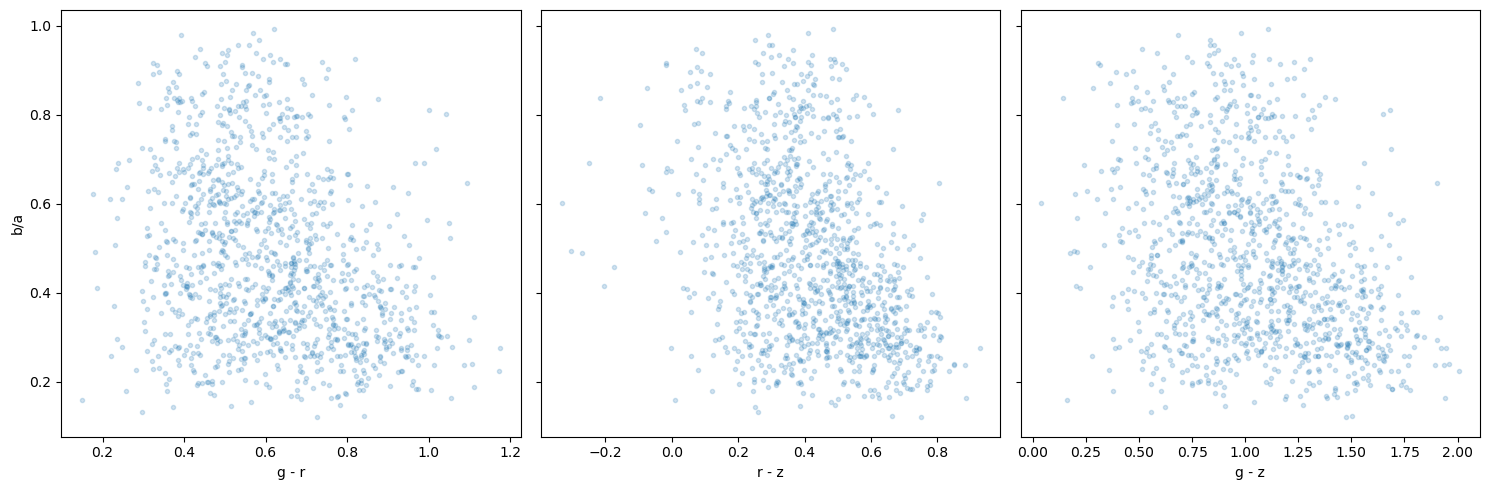

In [16]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))

ax[0].plot(gals['G_MAG_SB26_CORR'] - gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('b/a')

ax[1].plot(gals['R_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r - z')

ax[2].plot(gals['G_MAG_SB26_CORR'] - gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('g - z');

## Correlation between magnitude and axis ratio?

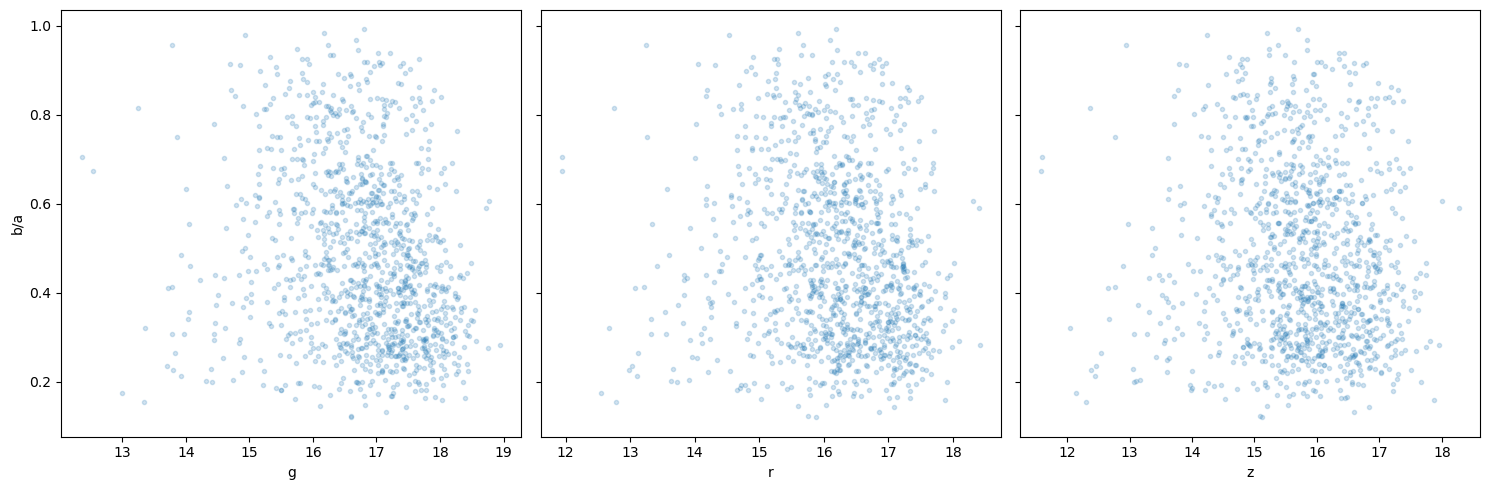

In [17]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[1].set_xlabel('r')

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['BA'], '.', alpha=0.2)
ax[2].set_xlabel('z');

## Correlation between magnitude, $R_{26}$, and axis ratio?

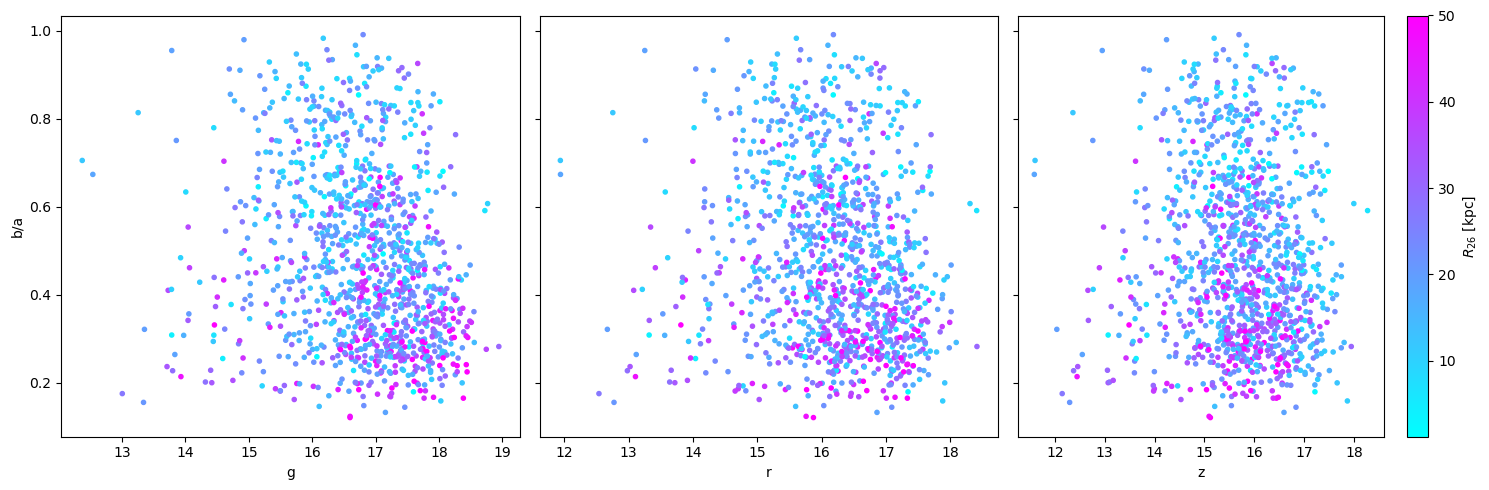

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))

ax[0].scatter(gals['G_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[0].set_xlabel('g')
ax[0].set_ylabel('b/a')

ax[1].scatter(gals['R_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[1].set_xlabel('r')

zplot = ax[2].scatter(gals['Z_MAG_SB26_CORR'], gals['BA'], c=gals['R26_kpc'], marker='.', vmax=50, cmap='cool')
ax[2].set_xlabel('z')

plt.colorbar(zplot, label='$R_{26}$ [kpc]');

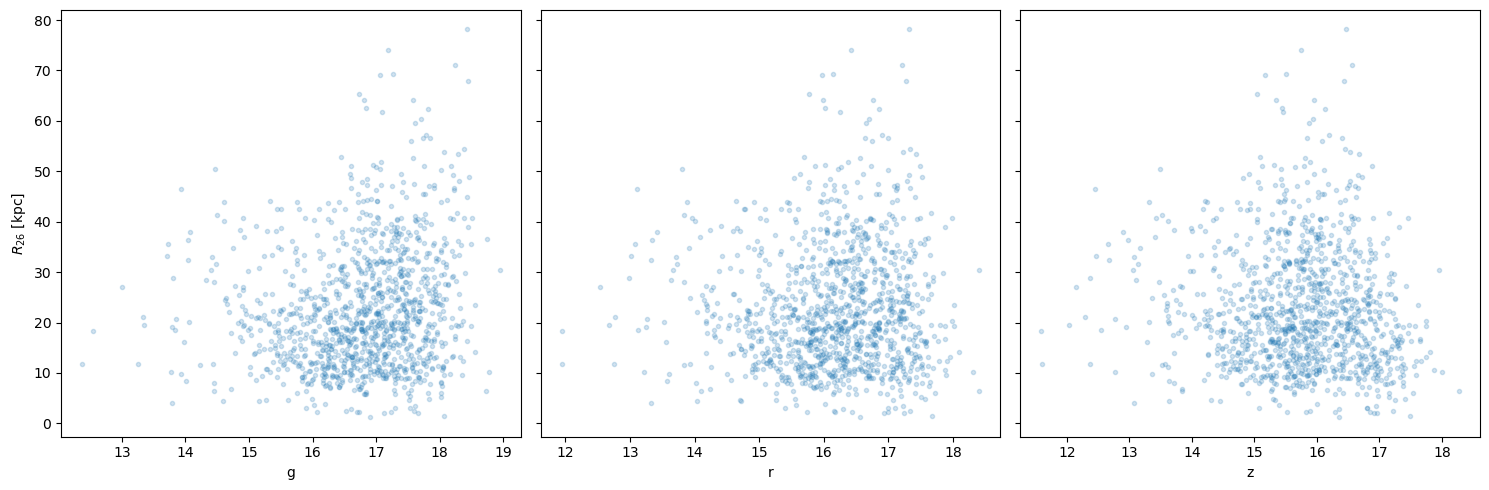

In [19]:
fig, ax = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))

ax[0].plot(gals['G_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[0].set_xlabel('g')
ax[0].set_ylabel('$R_{26}$ [kpc]')

ax[1].plot(gals['R_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[1].set_xlabel('r')

ax[2].plot(gals['Z_MAG_SB26_CORR'], gals['R26_kpc'], '.', alpha=0.2)
ax[2].set_xlabel('z');

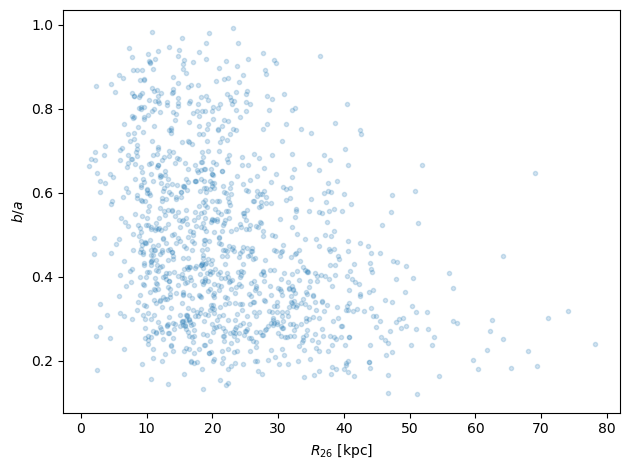

In [20]:
plt.figure(tight_layout=True)

plt.plot(gals['R26_kpc'], gals['BA'], '.', alpha=0.2)

plt.xlabel('$R_{26}$ [kpc]')
plt.ylabel('$b/a$');

## Let's try fitting a plane to ($m_r$, $b/a$, $R_{26}$)

We're going to let $x = b/a$, $y = R_{26}$, and $z = m_r$

### Calculate median $m_r$ in bins of ($b/a$, $R_{26}$)

In [16]:
ba = np.arange(0,1,0.1)
R26 = np.arange(0,80,5)
ba_grid, R26_grid = np.meshgrid(ba, R26)

mr_grid = np.nan*np.ones(ba_grid.shape)

for i in range(ba_grid.shape[1]):
    
    gals_subset_ba = gals[(gals['BA'] > i*0.1) & (gals['BA'] <= (i+1)*0.1)]
    
    for j in range(ba_grid.shape[0]):
        
        gals_R26_subset = gals_subset_ba[(gals_subset_ba['R26_kpc'] > j*5) & (gals_subset_ba['R26_kpc'] <= (j+1)*5)]
        
        mr_grid[j,i] = np.median(gals_R26_subset['R_MAG_SB26_CORR'])

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
# Do something to compute uncertainties in each of these bins

In [24]:
N = len(gals['R_MAG_SB26_CORR'])
N_grid = mr_grid.shape[0]*mr_grid.shape[1]

In [36]:
# Create covariance matrix, assuming each parameter is independent of the others
cov = np.empty((3, 3, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.001**2, 0., 0.], [0., gals['R26_kpc_err'][i]**2, 0.], [0., 0., gals['R_MAG_SB26_ERR_CORR'][i]**2]])
    

cov_grid = np.empty((3, 3, N_grid))

for i in range(N_grid):
    cov[:,:,i] = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [26]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.251973467837832


In [37]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
hf_grid = LinFit([np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid) - mr_median], cov_grid)

In [38]:
# Set bounds of coefficients
bounds = ((-100.0, 0.0), (-10.0, 10.0), (-100.0, 100.0), (1.0e-5, 50.))

In [39]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_grid.emcee(bounds, verbose=True)

     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60165
     nit: 1000
 success: False
       x: array([36.58532429, -2.64819196, 52.96787852, 46.75889611])


ValueError: Probability function returned NaN

In [46]:
# Calculate parameter values and covariance matrix
A_ba, B_R26, C, sig = np.median(mcmc_samples, axis=1)

cov_fit = np.cov(mcmc_samples)

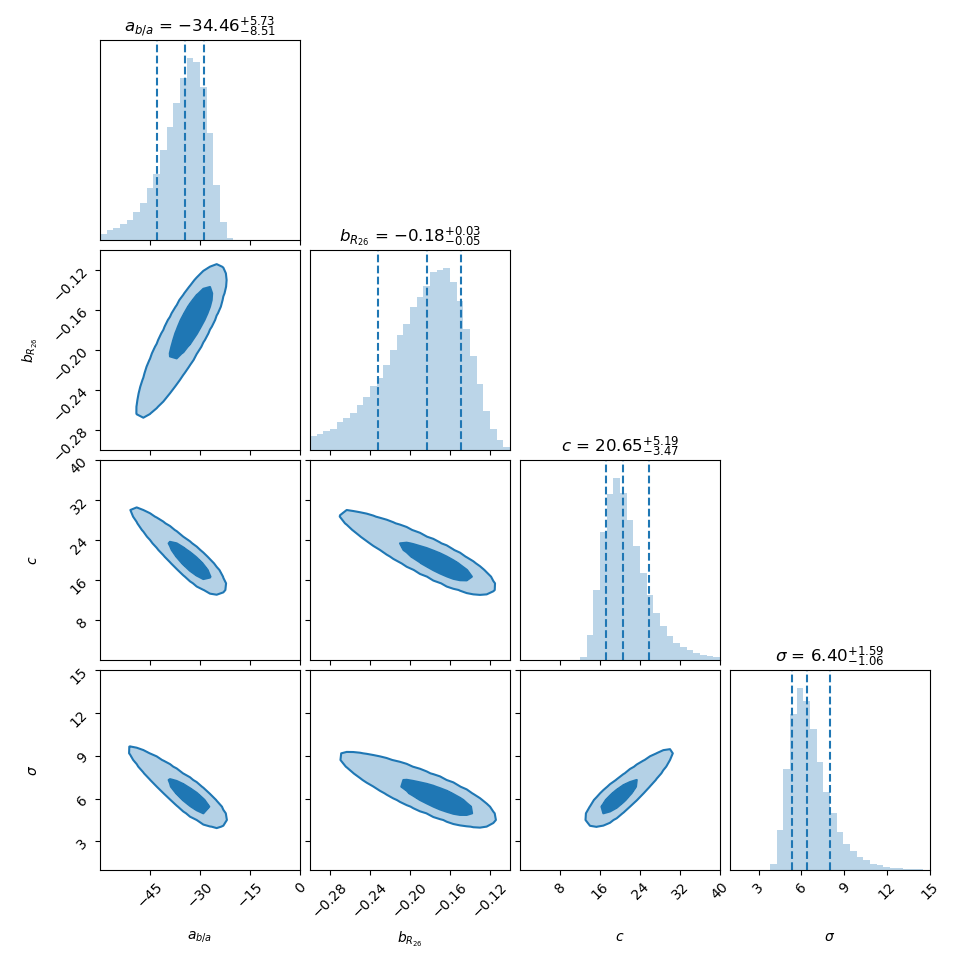

In [47]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-60, 0], [-0.3, -0.1], [0, 40], [1, 15]],
                    labels=['$a_{b/a}$', '$b_{R_{26}}$', '$c$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

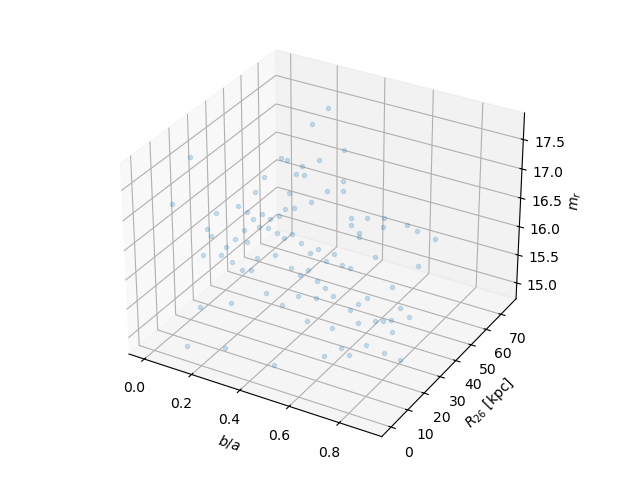

In [35]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

# ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
ax.plot(np.ravel(ba_grid), np.ravel(R26_grid), np.ravel(mr_grid), '.', alpha=0.2)

# ax.plot_wireframe(ba_grid, R26_grid, A_ba*ba_grid + B_R26*R26_grid + (C + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

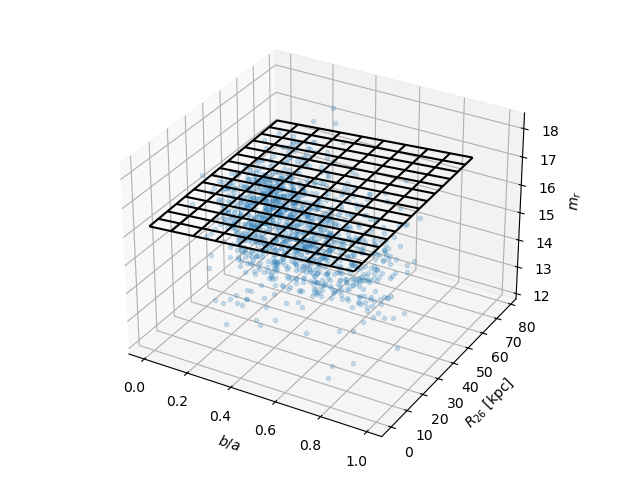

In [49]:
# Results from minimize: [0.59896149, 0.00317231, 0.01740659, 0.18515053]
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.plot(gals['BA'], gals['R26_kpc'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)

ax.plot_wireframe(ba_grid, R26_grid, 0.59896149*ba_grid + 0.00317231*R26_grid + (0.01740659 + mr_median), colors='k')

ax.set_xlabel('$b/a$')
ax.set_ylabel('$R_{26}$ [kpc]')
ax.set_zlabel('$m_r$');

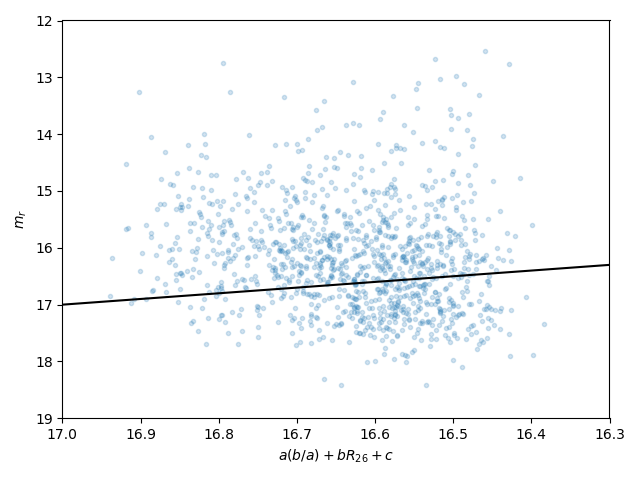

In [53]:
plt.figure(tight_layout=True)

plt.plot(0.59896149*gals['BA'] + 0.00317231*gals['R26_kpc'] + (0.01740659 + mr_median), 
         gals['R_MAG_SB26_CORR'], 
         '.', 
         alpha=0.2)

plt.plot([12, 18], [12, 18], 'k')

plt.xlim([17, 16.3])
plt.ylim([19, 12])

plt.xlabel('$a(b/a) + bR_{26} + c$')
plt.ylabel('$m_r$');

## Let's try fitting a line to ($m_r$, $b/a$)

We're going to let $x = b/a$ and $y = m_r$

In [16]:
ba_binwidth = 0.1
ba = np.arange(0.1, 1, ba_binwidth)

N = len(gals['R_MAG_SB26_CORR'])
N_bins = len(ba)

In [17]:
mr_bins = np.nan*np.ones(len(ba))
cov_bins = np.nan*np.ones((2, 2, N_bins))

for i in range(N_bins):
    gals_subset_ba = gals[(gals['BA'] > ba[i]) & (gals['BA'] <= ba[i]+ba_binwidth)]
    if len(gals_subset_ba) > 0:
        mr_bins[i] = np.median(gals_subset_ba['R_MAG_SB26_CORR'])
        cov_bins[:,:,i] = np.array([[0., 0.], [0., 1/len(gals_subset_ba)]])

In [18]:
# Create covariance matrix, assuming each parameter is independent of the others
cov = np.empty((2, 2, N))

for i in range(N):
    cov[:,:,i] = np.array([[0.001**2, 0.], [0., gals['R_MAG_SB26_ERR_CORR'][i]**2]])
    
'''
cov_bins = np.empty((2, 2, N_bins))

for i in range(N_bins):
    cov_bins[:,:,i] = np.array([[1., 0.], [0., 1.]])
''';

In [19]:
# Shift the pivot point (y-intercept) to minimize the correlations between the fit coefficients
mr_median = np.median(gals['R_MAG_SB26_CORR'])
print(mr_median)

16.251973467837832


In [26]:
# Create the Hyperfit object
# hf = LinFit([gals['BA'], gals['R_MAG_SB26_CORR'] - mr_median], cov)
# hf_bins = LinFit([ba[2:-2], mr_bins[2:-2] - mr_median], cov_bins[:,:,2:-2])
hf_bins = LinFit([ba[1:], mr_bins[1:] - mr_median], cov_bins[:,:,1:]) # The first bin is empty

In [27]:
# Set bounds of coefficients
bounds = ((-100.0, 1.0), (-1.0, 10.0), (1.0e-5, 50.))

In [28]:
# Run MCMC to fit plane
# mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
mcmc_samples, mcmc_lnlike = hf_bins.emcee(bounds, verbose=True)

     fun: -19.12659454650161
     jac: array([-0.00773426, -0.00579412,  0.00568328])
 message: 'Optimization terminated successfully.'
    nfev: 2446
     nit: 53
 success: True
       x: array([2.42283060e-01, 2.27750447e-01, 3.80036544e-06])


100%|██████████| 1000/1000 [00:00<00:00, 2036.39it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.91754952 31.65016971 79.52690087] / 3976.3450434615747


100%|██████████| 1000/1000 [00:00<00:00, 2110.89it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.67237934 28.1963333  38.24892321] / 1912.4461603614097


100%|██████████| 1000/1000 [00:00<00:00, 2111.76it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.03889191 39.77068963 43.6945301 ] / 2401.9445954884795


100%|██████████| 1000/1000 [00:00<00:00, 2112.22it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.75102577 46.10648754 47.87671891] / 2487.5512886325573


100%|██████████| 1000/1000 [00:00<00:00, 2118.36it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.59864536 43.94025666 48.76472052] / 2629.932267933452


100%|██████████| 1000/1000 [00:00<00:00, 2118.14it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.70796158 48.28412651 46.14285885] / 2685.3980789443035


100%|██████████| 1000/1000 [00:00<00:00, 2087.93it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.69859832 44.80258396 47.59896467] / 2434.9299160758464


100%|██████████| 1000/1000 [00:00<00:00, 1989.41it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.24857284 46.81295948 57.15403835] / 2857.701917287811


100%|██████████| 1000/1000 [00:00<00:00, 2072.84it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.52484612 46.79080558 54.14484181] / 2707.2420902805393


100%|██████████| 1000/1000 [00:00<00:00, 2079.78it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.99534621 48.19955868 53.72547065] / 2686.2735323054944


In [20]:
# Read in fit (if notebook already run)
temp_infile = open('fuji_internalDust_mcmc-20250205.pickle', 'rb')
mcmc_samples, mr_median = pickle.load(temp_infile)
temp_infile.close()

In [21]:
# Calculate parameter values and covariance matrix
A_ba, B, sig = np.median(mcmc_samples, axis=1)
'''
cov_fit = np.cov(mcmc_samples)
A_ba_err = np.sqrt(cov_fit[0,0])
B_err = np.sqrt(cov_fit[1,1])
'''
A_ba_err = np.std(mcmc_samples[0][(-1.5 < mcmc_samples[0]) & (mcmc_samples[0] < 0)])
B_err = np.std(mcmc_samples[1][(0 < mcmc_samples[1]) & (mcmc_samples[1] < 1)])

print(f'{A_ba:.2f} +/- {A_ba_err:.2f}')
print(f' {B:.2f} +/- {B_err:.2f}')

-1.05 +/- 0.18
 0.49 +/- 0.11


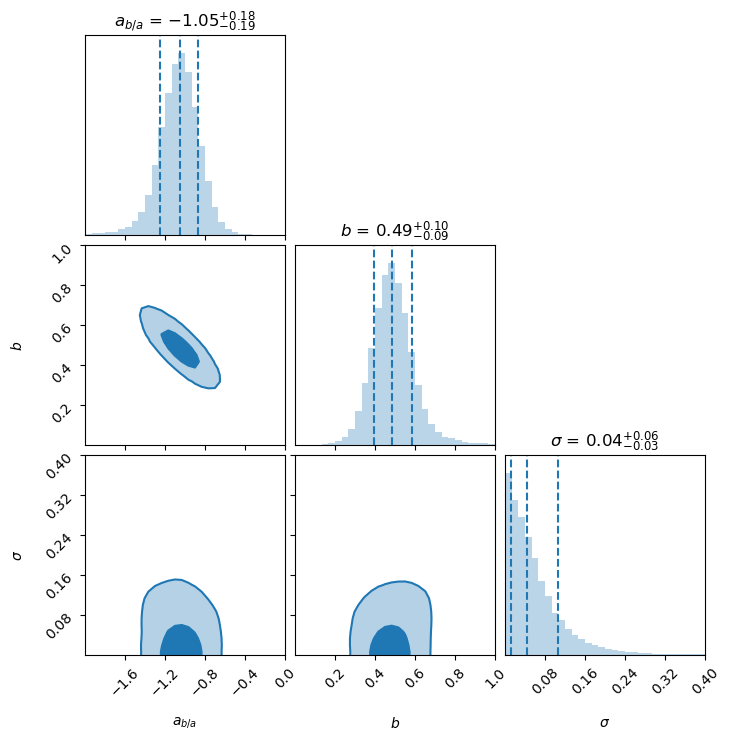

In [31]:
fig = corner.corner(mcmc_samples.T, 
                    bins=30, 
                    smooth=1, 
                    range=[[-2, 0], [0, 1], [0, 0.4]],
                    labels=['$a_{b/a}$', '$b$', r'$\sigma$'], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                    quantiles=[0.16, 0.5, 0.84], 
                    color='tab:blue', 
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
                    plot_datapoints=False,
                    fill_contours=True, 
                    show_titles=True);

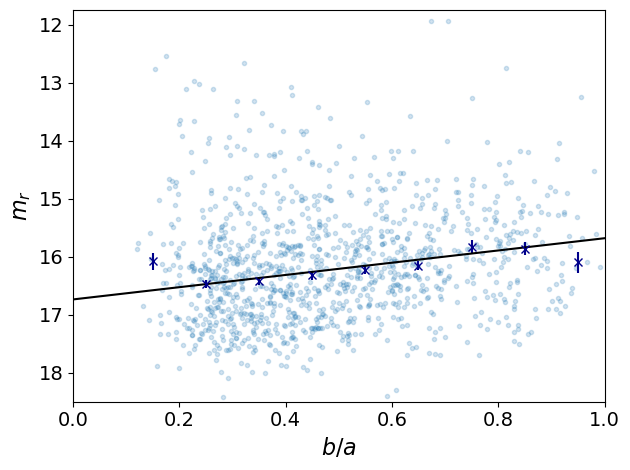

In [32]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['R_MAG_SB26_CORR'], '.', alpha=0.2)
# plt.errorbar(ba, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='tab:blue')
plt.errorbar(ba + 0.05, mr_bins, yerr=np.sqrt(cov_bins[1,1,:]), fmt='x', c='darkblue')

plt.plot(np.array([0,1]), A_ba*np.array([0,1]) + (B + mr_median), 'k')

plt.xlim([0, 1])
plt.ylim([18.5, 11.75])

plt.tick_params('both', which='major', labelsize=14)

plt.xlabel('$b/a$', fontsize=16)
plt.ylabel('$m_r$', fontsize=16);

plt.savefig('../../Figures/SV/fuji_internalDustCorr_20250205.png', 
            dpi=150, 
            facecolor='none');

### Save figure data for paper

In [28]:
hdr = fits.Header()

hdr['DESI_DR'] = 'EDR'
hdr['FIGURE'] = 2
hdr['SLOPE'] = float(f'{A_ba:.3f}')
hdr['SLOPE_ER'] = float(f'{A_ba_err:.3g}')
hdr['YINT'] = float(f'{(B + mr_median):.3f}')
hdr['YINT_ERR'] = float(f'{B_err:.3g}')

empty_primary = fits.PrimaryHDU(header=hdr)

In [30]:
data_hdu = fits.BinTableHDU(data=gals['BA', 'R_MAG_SB26_CORR'], 
                            name='EDR')
data_hdu.columns['R_MAG_SB26_CORR'].name = 'R_MAG' # rename column

median_hdu = fits.BinTableHDU(data=Table([ba, mr_bins, np.sqrt(cov_bins[1,1,:])], 
                                         names=('BA', 'R_MAG', 'R_MAG_ERR')), 
                              name='MEDIANS')

hdul = fits.HDUList([empty_primary, data_hdu, median_hdu])

hdul.writeto('paper_figures/Fig2/fig2_data.fits', overwrite=True)

### Save MCMC chains

In [33]:
temp_outfile = open('fuji_internalDust_mcmc-20250205.pickle', 'wb')
pickle.dump((mcmc_samples, mr_median), temp_outfile)
temp_outfile.close()